In [1]:
# ignore warnings 
import warnings
warnings.filterwarnings('ignore')
import os
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import ast
from bisect import bisect_left
# import Counter
from collections import Counter

from scipy.signal import find_peaks, correlate
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
load_dotenv()
base_dir = os.getenv("SCRATCH_DIR")
# base_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(base_dir, "data")
behav_data_dir = os.path.join(data_dir, "behav")
# stimuli_dir = os.path.join(base_dir, "stimuli")

In [3]:
df_1 = pd.read_csv(os.path.join(behav_data_dir, "prettymouth1.csv"))
df_2a = pd.read_csv(os.path.join(behav_data_dir, "prettymouth2a.csv"))
df_2b = pd.read_csv(os.path.join(behav_data_dir, "prettymouth2b.csv"))
df_1_postsurvey = pd.read_csv(os.path.join(behav_data_dir, "prettymouth1_postsurvey.csv"))
df_1_postsurvey = df_1_postsurvey.iloc[2:]
df_2_postsurvey = pd.read_csv(os.path.join(behav_data_dir, "prettymouth2_postsurvey.csv"))
df_2_postsurvey = df_2_postsurvey.iloc[2:]

In [4]:
df_1_reponse = df_1[~df_1["key_resp_2.rt"].isna()]
df_2a_reponse = df_2a[~df_2a["key_resp_2.rt"].isna()]
df_2b_reponse = df_2b[~df_2b["key_resp_2.rt"].isna()]

In [5]:
df1 = df_1_reponse[df_1_reponse["participant"].isin(df_1_postsurvey["participant"])]
df2a = df_2a_reponse[df_2a_reponse["participant"].isin(df_2_postsurvey["participant"])]
df2b = df_2b_reponse[df_2b_reponse["participant"].isin(df_2_postsurvey["participant"])]
df1_ps = df_1_postsurvey[df_1_postsurvey["participant"].isin(df1["participant"])]
df2a_ps = df_2_postsurvey[df_2_postsurvey["participant"].isin(df2a["participant"])]
df2b_ps = df_2_postsurvey[df_2_postsurvey["participant"].isin(df2b["participant"])]
print(f"df1 has {df1.shape[0]} rows")
print(f"df2a has {df2a.shape[0]} rows")
print(f"df2b has {df2b.shape[0]} rows")
print(f"df1_ps has {df1_ps.shape[0]} rows")
print(f"df2a_ps has {df2a_ps.shape[0]} rows")
print(f"df2b_ps has {df2b_ps.shape[0]} rows")

df1 has 115 rows
df2a has 63 rows
df2b has 59 rows
df1_ps has 114 rows
df2a_ps has 63 rows
df2b_ps has 59 rows


In [6]:
df2a_ps[["ch1", "ch2", "ch3", "recall"]]

,ch1,ch2,ch3,recall
2,Lee,Arthur,Joanie,The woman was asleep in Lee's bed while arthur...
6,Lee,Arthur,Don't know,Arthur called Lee asking if he saw his wife Jo...
8,Lee,Arthur,Joanie,A grey haired man is lying in bed with a girl....
10,Lee,Arthur,Joanie,"The story starts out, with a grey haired man n..."
11,Lee,Arthur,Joanie,Arthur called Lee at his house to ask him if h...
...,...,...,...,...
125,Lee,Arthur,Don't know,The beginning of the story described a grey-ha...
126,Lee,Arthur,Mary,Arthur and his wife go to a party and he gets ...
127,Arthur,Lee,Joanie,"The gray haired man, Arthur, was laying in bed..."
129,Lee,Arthur,Joanie,Arthur called his friend Lee in order to ask a...


In [7]:
def plot_scatter(df, group):
    df['key_resp_2.rt'] = df['key_resp_2.rt'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df_exploded = df[['key_resp_2.rt', 'participant']].explode('key_resp_2.rt')
    participants = df_exploded['participant'].unique()

    # Assign a unique y-value (level) for each participant
    participant_levels = {participant: i for i, participant in enumerate(participants, start=1)}

    # Create a new figure for the adjusted plot
    plt.figure(figsize=(12, 8))

    # Iterate over each participant to plot their reaction times
    for participant, level in participant_levels.items():
        # Get the reaction times for this participant
        participant_data = df_exploded[df_exploded['participant'] == participant]
        reaction_times = participant_data['key_resp_2.rt']
        
        # Plot each reaction time for this participant at their assigned y-level
        plt.scatter(reaction_times, [level] * len(reaction_times), label=participant, s=10)

    # Adjust the y-axis to show participant labels instead of numeric levels
    # plt.yticks(list(participant_levels.values()), list(participant_levels.keys()))
    plt.ylabel('Participant ID')
    plt.xlabel('Seconds')
    plt.title(f'{group}')
    # plt.legend(title='Participant ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [8]:
def plot_line_direct(df, group):
    df['key_resp_2.rt'] = df['key_resp_2.rt'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    
    # Explode 'key_resp_2.rt' to have a flat structure
    df_exploded = df[['key_resp_2.rt', 'participant']].explode('key_resp_2.rt')
    
    # Convert 'key_resp_2.rt' to numeric values
    df_exploded['key_resp_2.rt'] = pd.to_numeric(df_exploded['key_resp_2.rt'])
    
    # Count occurrences of each reaction time
    rt_counts = df_exploded['key_resp_2.rt'].value_counts().sort_index().reset_index()
    rt_counts.columns = ['Reaction Time', 'Number of Participants']
    
    # Plot
    plt.figure(figsize=(12, 8))
    
    # Plotting the line plot
    plt.plot(rt_counts['Reaction Time'], rt_counts['Number of Participants'], marker='o', linestyle='-')
    
    plt.xlabel('Seconds')
    plt.ylabel('Number of Participants')
    plt.title(f'{group}')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [9]:
def plot_line(df, group):
    df['key_resp_2.rt'] = df['key_resp_2.rt'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    
    # Explode 'key_resp_2.rt' to have a flat structure
    df_exploded = df[['key_resp_2.rt', 'participant']].explode('key_resp_2.rt')
    
    # Convert 'key_resp_2.rt' to numeric values
    df_exploded['key_resp_2.rt'] = pd.to_numeric(df_exploded['key_resp_2.rt'])

    # Bin reaction times to count participants per bin
    # Define bins (adjust the range and bin size as needed)
    bins = np.linspace(df_exploded['key_resp_2.rt'].min(), df_exploded['key_resp_2.rt'].max(), 20)
    
    # Assign each reaction time to a bin
    df_exploded['rt_bin'] = pd.cut(df_exploded['key_resp_2.rt'], bins=bins, include_lowest=True)
    
    # Count unique participants per bin
    participants_per_bin = df_exploded.groupby('rt_bin')['participant'].nunique().reset_index(name='count')

    # Plot
    plt.figure(figsize=(12, 8))
    
    # Plotting the line plot
    plt.plot(participants_per_bin['rt_bin'].astype(str), participants_per_bin['count'], marker='o', linestyle='-')
    
    plt.xticks(rotation=45, ha="right")
    plt.ylabel('Number of Participants')
    plt.xlabel('Seconds')
    plt.title(f'{group}')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

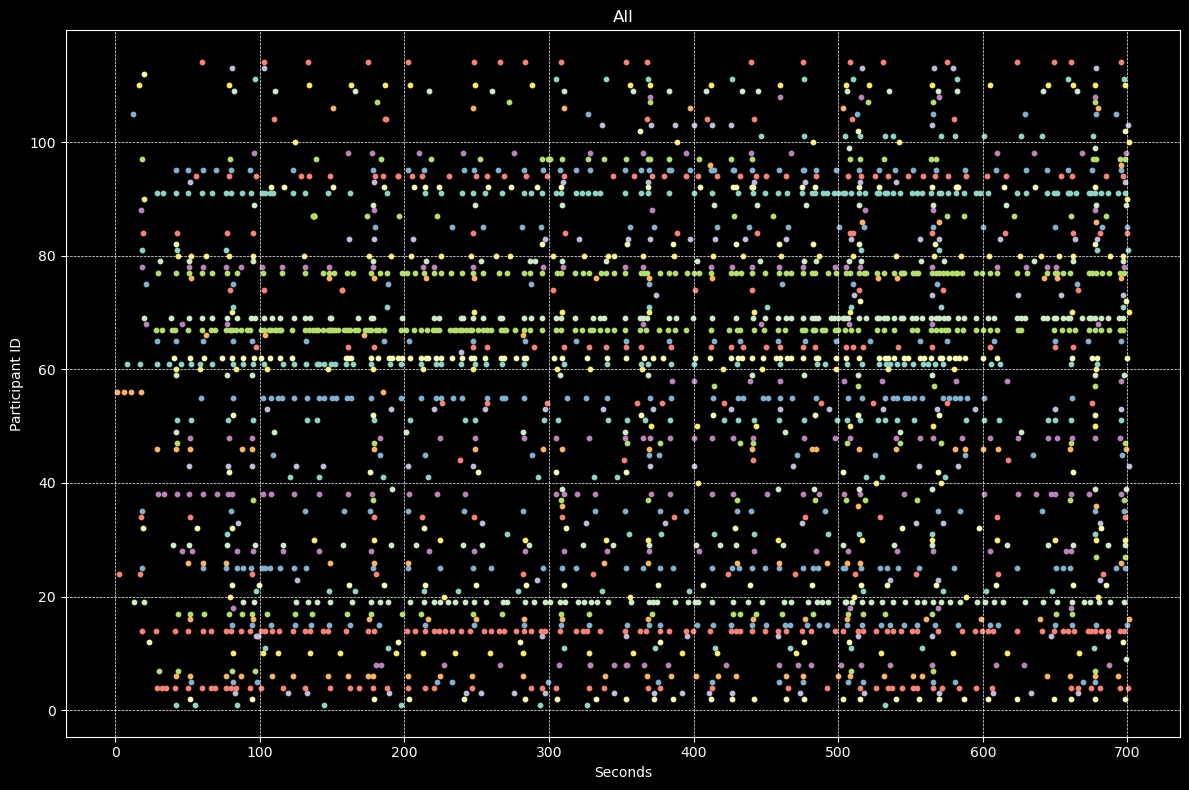

In [10]:
plot_scatter(df1, "All")

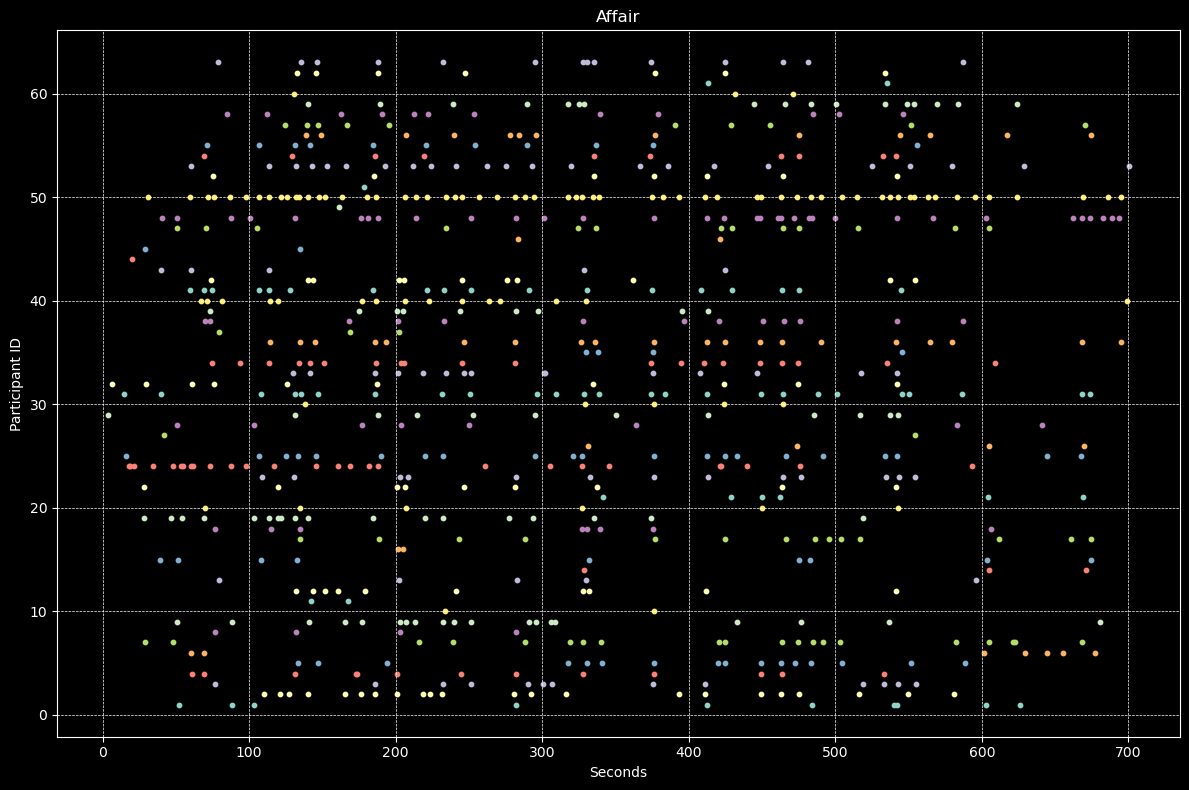

In [11]:
plot_scatter(df2a, "Affair")

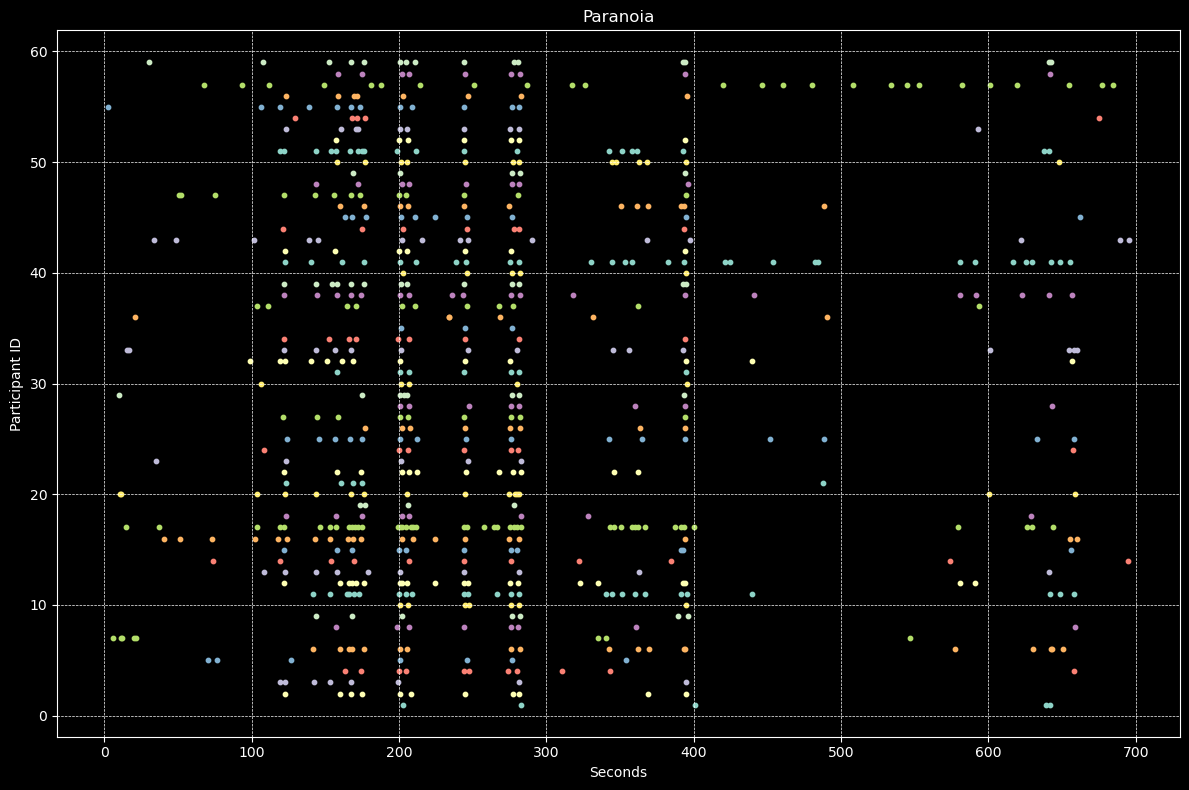

In [12]:
plot_scatter(df2b, "Paranoia")

In [15]:
df2a['key_resp_2.rt']

2      [52.02500000000001, 88.35229999995232, 103.501...
6      [110.06730000001193, 120.88680000001193, 126.9...
18     [76.84360000002386, 185.7455, 232.162200000047...
22     [61.032599999999626, 69.18270000000018, 131.43...
26     [133.3055, 146.8922000000477, 193.798299999952...
                             ...                        
274    [139.85399999999981, 189.3074999999999, 238.72...
278    [130.84400000000002, 431.54900000000004, 471.331]
286               [412.9442000002861, 535.1584000000954]
290    [132.83889999999107, 145.26659999999404, 188.0...
294    [78.63989999997615, 135.36369999998809, 145.99...
Name: key_resp_2.rt, Length: 63, dtype: object

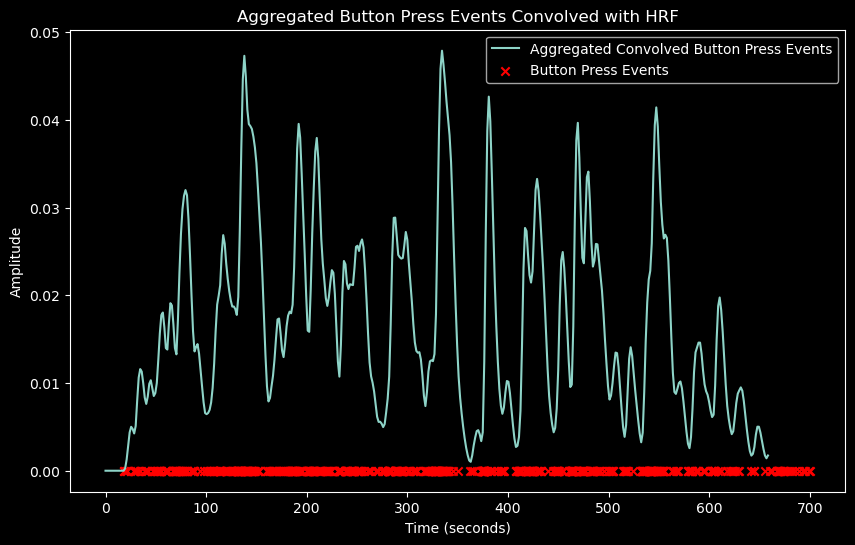

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial

# Custom HRF function
def custom_hrf(t, T0=0, n=4, lambd=2):
    h = np.zeros_like(t)
    mask = t > T0
    h[mask] = ((t[mask] - T0)**(n-1) / (lambd**n * factorial(n-1))) * np.exp(-(t[mask] - T0) / lambd)
    return h

# Generate HRF
tr = 1.5
duration = 660  # seconds
time_grid = np.arange(0, duration, tr)
hrf = custom_hrf(time_grid)

# Importing pandas and loading your participant data
import pandas as pd

# Assuming df2a is already defined and contains your participant data
# Example of creating df2a
# df2a = pd.DataFrame({'key_resp_2.rt': [[52.025, 88.352, ...], [110.067, 120.886, ...], ...]})

# Extracting button press times
responses = df2a['key_resp_2.rt'].tolist()

# Adjust button press times based on stimuli appearance
stimulus_start = 12 * tr  # 12th TR
stimulus_end = 467 * tr  # 467th TR

# Filter button presses within stimulus period
filtered_responses = []
for button_press_times in responses:
    filtered_times = [time for time in button_press_times if stimulus_start <= time <= stimulus_end]
    filtered_responses.append(filtered_times)

# Number of participants
n_participants = len(filtered_responses)

# Direct convolution for each participant and aggregate
aggregate_convolved_response = np.zeros_like(time_grid)
all_button_press_times = []

for button_press_times in filtered_responses:
    all_button_press_times.extend(button_press_times)

    # Create binary button press time series
    button_press_series = np.zeros_like(time_grid)
    press_indices = np.searchsorted(time_grid, button_press_times)
    button_press_series[press_indices-1] = 1

    # Convolve button press events with HRF
    convolved_response = np.convolve(button_press_series, hrf, mode='full')[:len(time_grid)]

    # Sum the convolved responses for aggregation
    aggregate_convolved_response += convolved_response

# Normalize the aggregate convolved response by the number of participants
aggregate_convolved_response /= n_participants

# Plot the aggregate convolved response
plt.figure(figsize=(10, 6))
plt.plot(time_grid, aggregate_convolved_response, label='Aggregated Convolved Button Press Events')
plt.scatter(all_button_press_times, np.zeros_like(all_button_press_times), color='red', marker='x', label='Button Press Events')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Aggregated Button Press Events Convolved with HRF')
plt.legend()
plt.show()

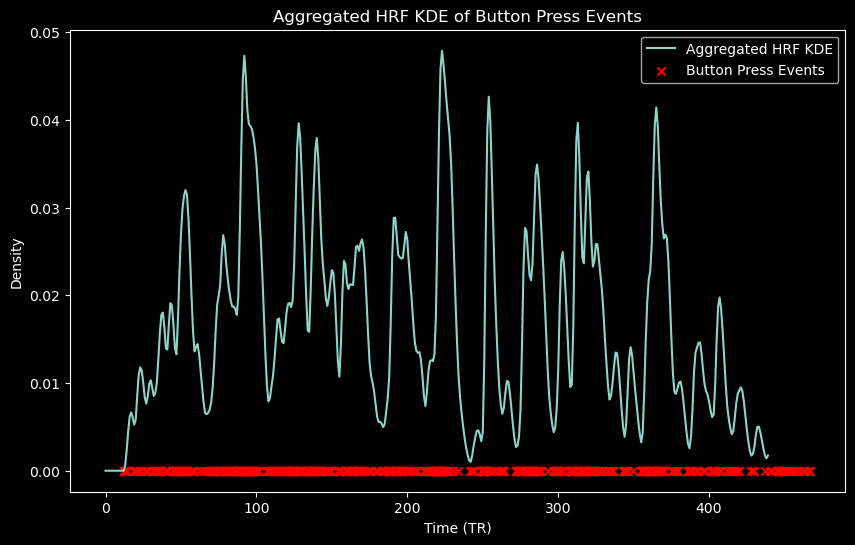

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial
import pandas as pd

# Custom HRF function
def custom_hrf(t, T0=0, n=4, lambd=2):
    h = np.zeros_like(t)
    mask = t > T0
    h[mask] = ((t[mask] - T0)**(n-1) / (lambd**n * factorial(n-1))) * np.exp(-(t[mask] - T0) / lambd)
    return h

# Generate HRF in TR units
tr = 1.5
duration = 660  # seconds
n_trs = int(duration / tr)
time_grid_tr = np.arange(n_trs)  # time grid in TR units
hrf_tr = custom_hrf(time_grid_tr * tr)  # HRF in TR units

# Load participant data (example)
# Assuming df2a is already defined and contains your participant data
# Example of creating df2a
# df2a = pd.DataFrame({'key_resp_2.rt': [[52.025, 88.352, ...], [110.067, 120.886, ...], ...]})

# Extracting button press times
responses = df2a['key_resp_2.rt'].tolist()

# Adjust button press times based on stimuli appearance
stimulus_start = 12  # 12th TR
stimulus_end = 467  # 467th TR

# Filter button presses within stimulus period
filtered_responses = []
for button_press_times in responses:
    filtered_times = [time for time in button_press_times if stimulus_start * tr <= time <= stimulus_end * tr]
    filtered_responses.append(filtered_times)

# Number of participants
n_participants = len(filtered_responses)

# Perform KDE with HRF as kernel for each participant and aggregate
aggregate_kde_response_tr = np.zeros_like(time_grid_tr, dtype=float)  # Ensure dtype is float
all_button_press_times_tr = []

for button_press_times in filtered_responses:
    all_button_press_times_tr.extend([time / tr for time in button_press_times])  # Convert to TR units

    for press_time in button_press_times:
        onset = int(press_time // tr)  # Onset in TR units
        if onset + len(hrf_tr) <= len(aggregate_kde_response_tr):
            aggregate_kde_response_tr[onset:onset + len(hrf_tr)] += hrf_tr
        else:
            remaining_length = len(aggregate_kde_response_tr) - onset
            if remaining_length > 0:
                aggregate_kde_response_tr[onset:] += hrf_tr[:remaining_length]

# Normalize the aggregate KDE response by the number of participants
aggregate_kde_response_tr /= n_participants

# Plot the aggregate KDE response
plt.figure(figsize=(10, 6))
plt.plot(time_grid_tr, aggregate_kde_response_tr, label='Aggregated HRF KDE')
plt.scatter(np.array(all_button_press_times_tr), np.zeros_like(all_button_press_times_tr), color='red', marker='x', label='Button Press Events')
plt.xlabel('Time (TR)')
plt.ylabel('Density')
plt.title('Aggregated HRF KDE of Button Press Events')
plt.legend()
plt.show()

## Seconds to TRs (bin methods)

In [26]:
def seconds2TRs(resp_seconds):
    resp_seconds = np.array(resp_seconds)
    resp_TRs = np.ceil(resp_seconds / 1.5)
    resp_TRs = np.unique(resp_TRs)
    return resp_TRs

def plot_scatter_TR(df, group):
    df['key_resp_2.rt'] = df['key_resp_2.rt'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df['key_resp_2.TR'] = df['key_resp_2.rt'].apply(lambda x: np.around(x, decimals=3))
    df['key_resp_2.TR'] = df['key_resp_2.TR'].apply(seconds2TRs)
    df_exploded = df[['key_resp_2.TR', 'participant']].explode('key_resp_2.TR')
    participants = df_exploded['participant'].unique()

    # Assign a unique y-value (level) for each participant
    participant_levels = {participant: i for i, participant in enumerate(participants, start=1)}

    # Create a new figure for the adjusted plot
    plt.figure(figsize=(12, 8))

    # Iterate over each participant to plot their reaction times
    for participant, level in participant_levels.items():
        # Get the reaction times for this participant
        participant_data = df_exploded[df_exploded['participant'] == participant]
        reaction_times = participant_data['key_resp_2.TR']
        
        # Plot each reaction time for this participant at their assigned y-level
        plt.scatter(reaction_times, [level] * len(reaction_times), label=participant, s=10)

    # Adjust the y-axis to show participant labels instead of numeric levels
    # plt.yticks(list(participant_levels.values()), list(participant_levels.keys()))
    plt.ylabel('Participant ID')
    # plt.xlabel('Bottom Press Timepoint')
    plt.title(f'{group} Group')
    # plt.legend(title='Participant ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


def plot_line_direct_TR(df, group):
    df['key_resp_2.rt'] = df['key_resp_2.rt'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df['key_resp_2.TR'] = df['key_resp_2.rt'].apply(lambda x: np.around(x, decimals=3))
    df['key_resp_2.TR'] = df['key_resp_2.TR'].apply(seconds2TRs)
    df_exploded = df[['key_resp_2.TR', 'participant']].explode('key_resp_2.TR')
    
    # Convert 'key_resp_2.rt' to numeric values
    df_exploded['key_resp_2.TR'] = pd.to_numeric(df_exploded['key_resp_2.TR'])
    
    # Count occurrences of each reaction time
    rt_counts = df_exploded['key_resp_2.TR'].value_counts().sort_index().reset_index()
    rt_counts.columns = ['Reaction Time', 'Number of Participants']
    
    # Plot
    plt.figure(figsize=(12, 8))
    
    # Plotting the line plot
    plt.plot(rt_counts['Reaction Time'], rt_counts['Number of Participants'], marker='o', linestyle='-')
    
    plt.xlabel('TRs')
    plt.ylabel('Number of Participants')
    plt.title(f'{group}')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

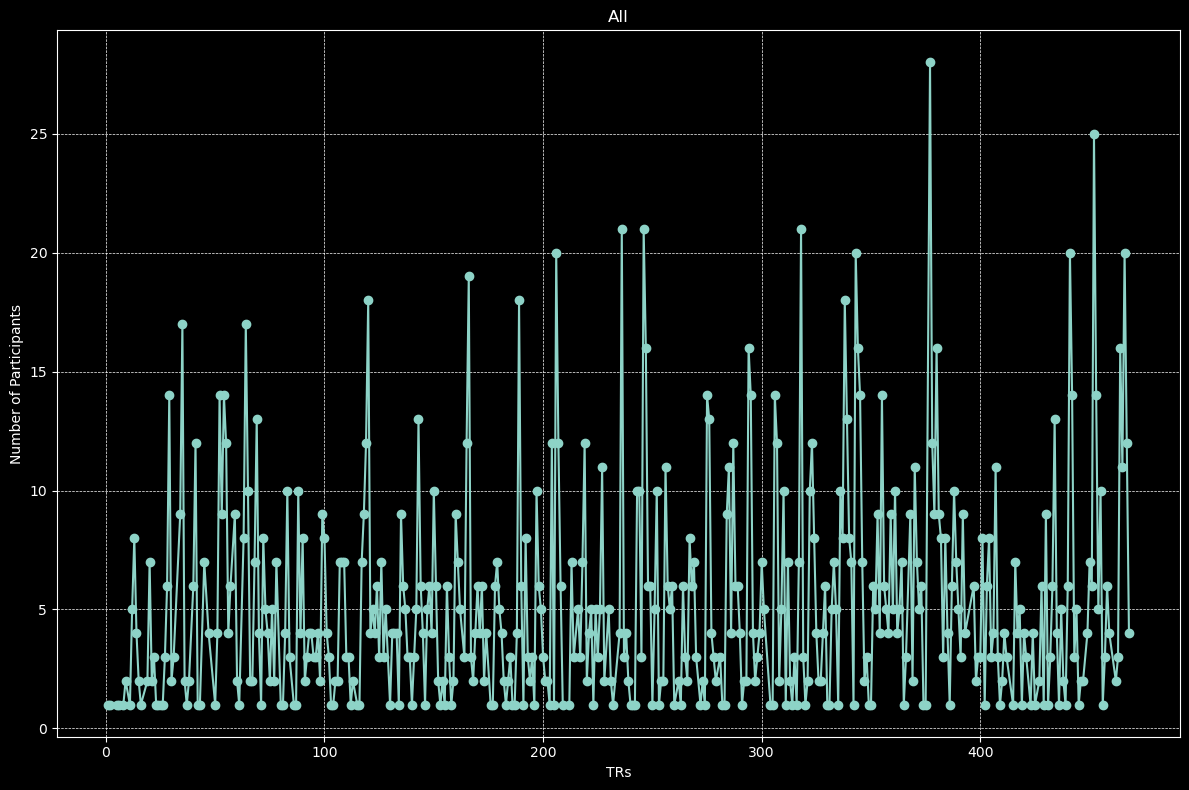

In [27]:
plot_line_direct_TR(df1, "All")

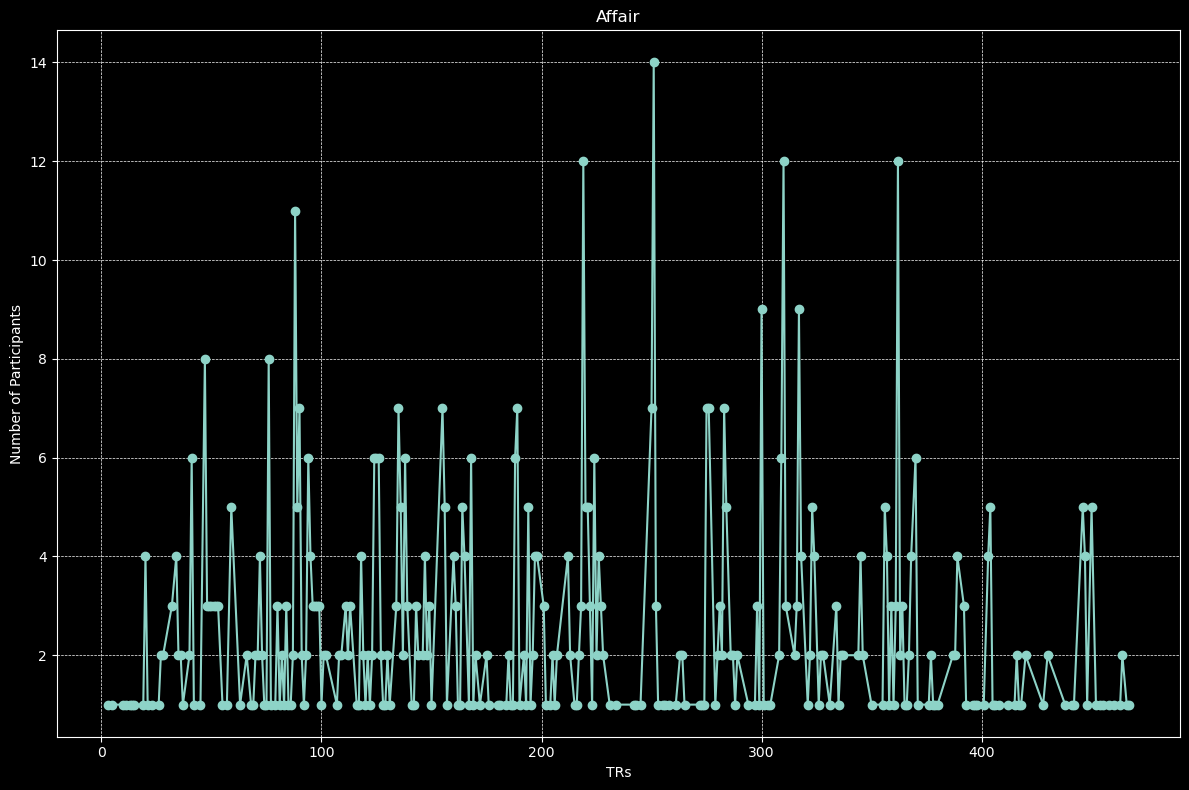

In [28]:
plot_line_direct_TR(df2a, "Affair")

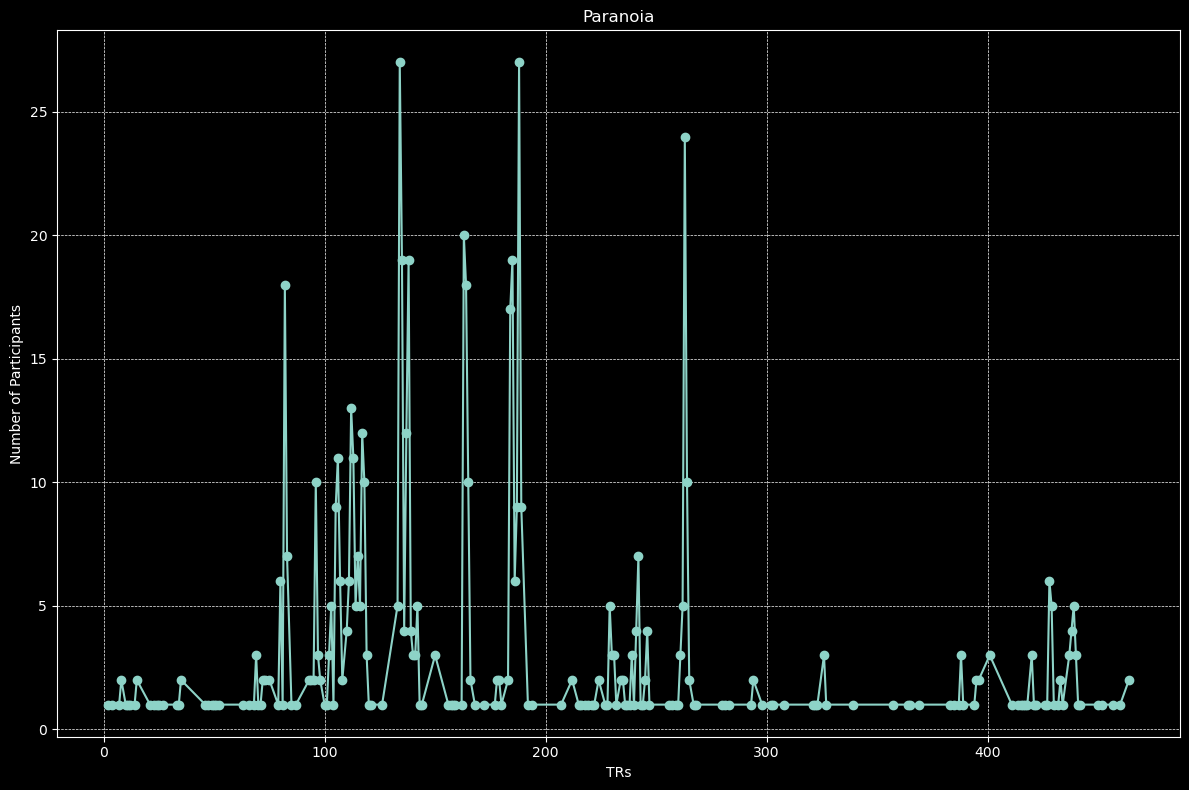

In [29]:
plot_line_direct_TR(df2b, "Paranoia")

### Get agreement

In [30]:
def get_agreement(df):
    df['key_resp_2.rt'] = df['key_resp_2.rt'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df['key_resp_2.TR'] = df['key_resp_2.rt'].apply(lambda x: np.around(x, decimals=3))
    df['key_resp_2.TR'] = df['key_resp_2.TR'].apply(seconds2TRs)
    response_col = 'key_resp_2.TR'
    unit = 'TR'
    all_responses = []
    for i, row in enumerate(df[response_col]):
        # Skip over None or NaN values
        if row is None or (isinstance(row, float) and np.isnan(row)):
            continue
        all_responses.extend(row)
    # Count the occurrences of each unique element
    response_counts = Counter(all_responses)
    # Create a new DataFrame
    agreement_df = pd.DataFrame(list(response_counts.items()), columns=[unit, 'count'])
    # drop nan based on TR
    agreement_df = agreement_df.dropna(subset=[unit])
    # Sort by TR for better readability
    agreement_df = agreement_df.sort_values(by=unit).reset_index(drop=True)
    agreement_df['agreement'] = agreement_df['count'] / df.shape[0]
    # remove the first 14 TRs/21s and the last 3 TRs
    if unit == 'TR':
        agreement_df = agreement_df[(agreement_df[unit] > 14)&(agreement_df[unit] < 467)]
    elif unit == 'second':
        agreement_df = agreement_df[(agreement_df[unit] > 21)&(agreement_df[unit] < 699)]
    else:
        print("Please enter a valid unit: TR or second")
    # reset index
    agreement_df = agreement_df.reset_index(drop=True)
    return agreement_df

In [31]:
agree_TR_df1 = get_agreement(df1)
agree_TR_df2a = get_agreement(df2a)
agree_TR_df2b = get_agreement(df2b)

In [32]:
agree_TR_df1

,TR,count,agreement
0,15.0,2,0.017391
1,16.0,1,0.008696
2,19.0,2,0.017391
3,20.0,7,0.060870
4,21.0,2,0.017391
...,...,...,...
407,462.0,2,0.017391
408,463.0,3,0.026087
409,464.0,16,0.139130
410,465.0,11,0.095652


In [33]:
agree_TR_df2a

,TR,count,agreement
0,15.0,1,0.015873
1,19.0,1,0.015873
2,20.0,4,0.063492
3,21.0,1,0.015873
4,23.0,1,0.015873
...,...,...,...
270,458.0,1,0.015873
271,460.0,1,0.015873
272,463.0,1,0.015873
273,464.0,2,0.031746


In [36]:
peaks

array([  2,   9,  14,  17,  26,  28,  33,  37,  40,  42,  44,  48,  50,
        54,  61,  66,  68,  71,  74,  78,  83,  86,  89,  93,  96,  98,
       100, 103, 107, 110, 112, 114, 119, 123, 125, 127, 130, 135, 138,
       144, 149, 151, 160, 167, 173, 177, 179, 184, 187, 189, 195, 199,
       203, 206, 209, 214, 218, 221, 224, 226, 231, 234, 240, 248, 254,
       257, 259, 263, 266, 273])

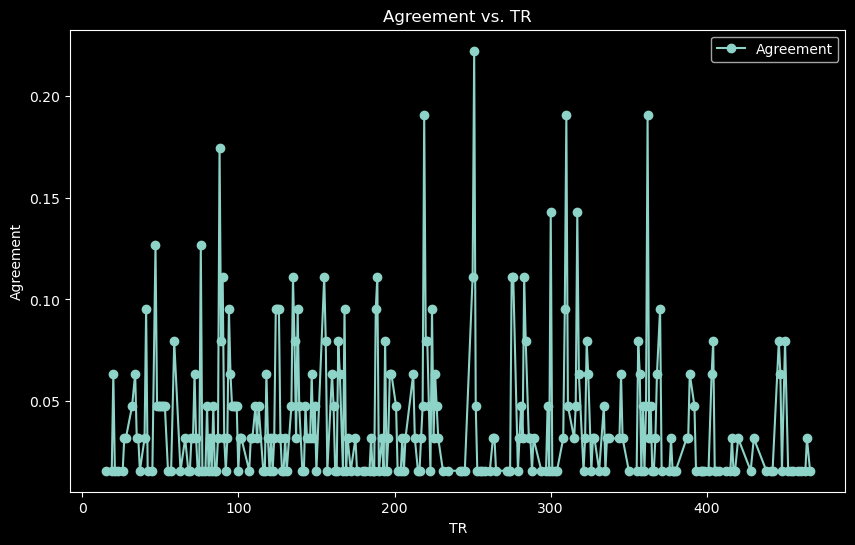

In [38]:
peaks, _ = find_peaks(agree_TR_df2a['agreement'], prominence=0.15)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(agree_TR_df2a['TR'], agree_TR_df2a['agreement'], label='Agreement', marker='o')
plt.xlabel('TR')
plt.ylabel('Agreement')
plt.title('Agreement vs. TR')
plt.legend()

# Highlight peaks in agreement
# plt.scatter(agree_TR_df2a['TR'].iloc[peaks], agree_TR_df2a['agreement'].iloc[peaks], color='red', label='Peaks')

plt.legend()
plt.show()

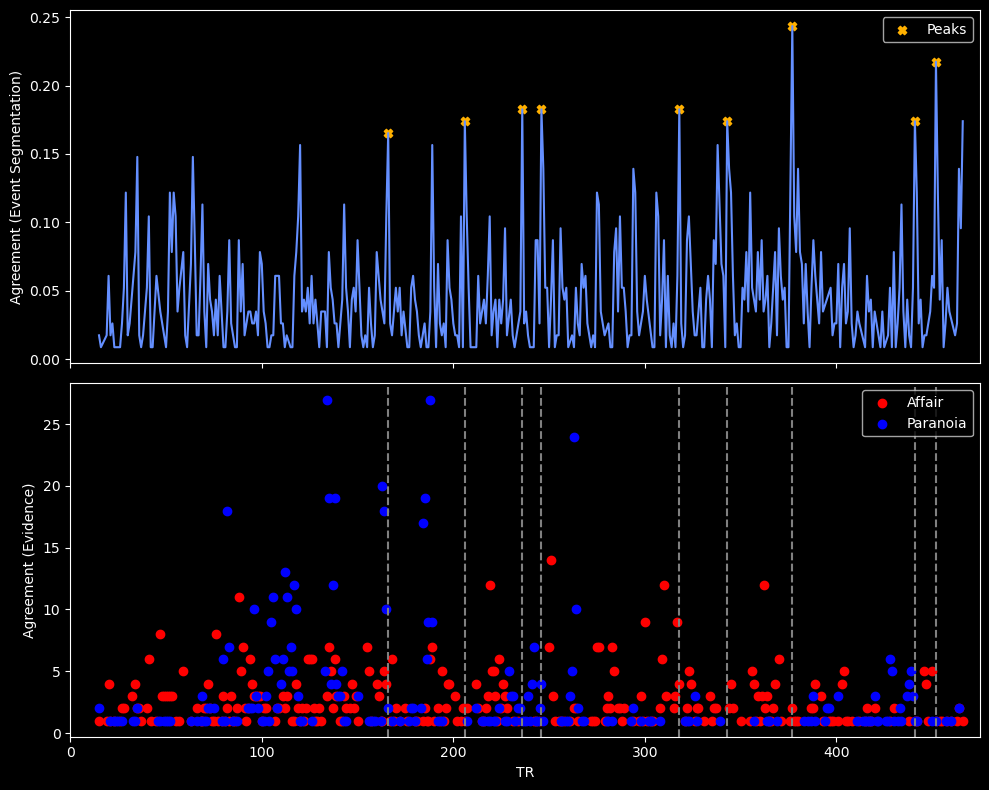

In [34]:
# Finding peaks in df1
prominent_peaks, _ = find_peaks(agree_TR_df1['agreement'], prominence=0.15)

# Setting up the plot
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

# Plotting df1 with peaks
axs[0].plot(agree_TR_df1['TR'], agree_TR_df1['agreement'], color='#648FFF')
axs[0].scatter(agree_TR_df1['TR'].iloc[prominent_peaks], agree_TR_df1['agreement'].iloc[prominent_peaks], marker='X', color='#FFB000', label='Peaks')
for peak in prominent_peaks:
    axs[1].axvline(x=agree_TR_df1['TR'].iloc[peak], linestyle='--', color='grey')

# Plotting df2a and df2b on the second subplot
axs[1].scatter(agree_TR_df2a['TR'], agree_TR_df2a['count'], label='Affair', color='red')
axs[1].scatter(agree_TR_df2b['TR'], agree_TR_df2b['count'], label='Paranoia', color='blue')

# axs[1].plot(agree_TR_df2a['TR'], agree_TR_df2a['agreement'], label='Affair', color='red')
# axs[1].plot(agree_TR_df2b['TR'], agree_TR_df2b['agreement'], label='Paranoia', color='blue')


# Making sure the x-axis covers the specified range from 0 to 475
axs[1].set_xlim([0, 475])

# Adding legends and labels
axs[0].legend()
axs[1].legend(loc='upper right')
axs[0].set_ylabel('Agreement (Event Segmentation)')
axs[1].set_ylabel('Agreement (Evidence)')
axs[1].set_xlabel('TR')

plt.tight_layout()
plt.show()


## Add RMS

In [22]:
output_dir = os.path.join(base_dir, "output")
rms_group_inter = os.path.join(output_dir, "RMS_group_inter_coflt", "400parcel")
rms_group_inter_affair_global = np.load(os.path.join(rms_group_inter, "rms_affair_global.npy"))
rms_group_inter_paranoia_global = np.load(os.path.join(rms_group_inter, "rms_paranoia_global.npy"))
print(rms_group_inter_affair_global.shape, rms_group_inter_paranoia_global.shape)

(1, 475) (1, 475)


In [23]:
agree_TR_df2a

,TR,count,agreement
0,15.0,1,0.015873
1,19.0,1,0.015873
2,20.0,4,0.063492
3,21.0,1,0.015873
4,23.0,1,0.015873
...,...,...,...
270,458.0,1,0.015873
271,460.0,1,0.015873
272,463.0,1,0.015873
273,464.0,2,0.031746


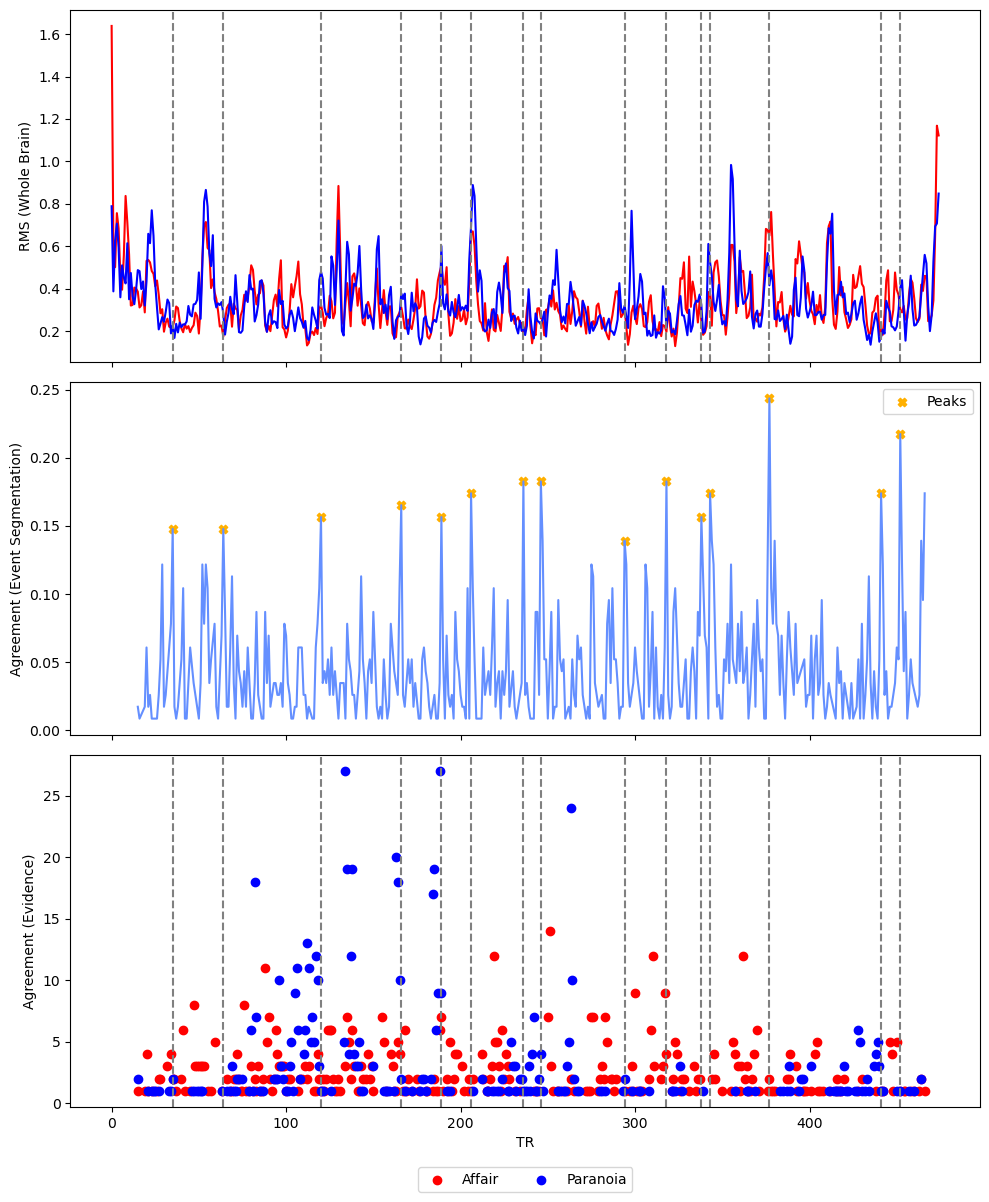

In [24]:

# Finding peaks in df1
prominent_peaks, _ = find_peaks(agree_TR_df1['agreement'], prominence=0.12)

# Setting up the plot
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 12))

# plot rms
axs[0].plot(rms_group_inter_affair_global.T, color='red')  
axs[0].plot(rms_group_inter_paranoia_global.T, color='blue')  

# Plotting df1 with peaks
axs[1].plot(agree_TR_df1['TR'], agree_TR_df1['agreement'], color='#648FFF')
axs[1].scatter(agree_TR_df1['TR'].iloc[prominent_peaks], agree_TR_df1['agreement'].iloc[prominent_peaks], marker='X', color='#FFB000', label='Peaks')
for peak in prominent_peaks:
    axs[0].axvline(x=agree_TR_df1['TR'].iloc[peak], linestyle='--', color='grey')
    axs[2].axvline(x=agree_TR_df1['TR'].iloc[peak], linestyle='--', color='grey')

# Plotting df2a and df2b on the second subplot
axs[2].scatter(agree_TR_df2a['TR'], agree_TR_df2a['count'], label='Affair', color='red')
axs[2].scatter(agree_TR_df2b['TR'], agree_TR_df2b['count'], label='Paranoia', color='blue')

# axs[2].plot(agree_TR_df2a['TR'], agree_TR_df2a['agreement'], label='Affair', color='red')
# axs[2].plot(agree_TR_df2b['TR'], agree_TR_df2b['agreement'], label='Paranoia', color='blue')


# Making sure the x-axis covers the specified range from 0 to 475
# axs[2].set_xlim([15, 466])

# Adding legends and labels
# axs[0].legend(loc='upper right')
axs[1].legend()
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, - 0.15), ncol=2)
axs[0].set_ylabel('RMS (Whole Brain)')
axs[1].set_ylabel('Agreement (Event Segmentation)')
axs[2].set_ylabel('Agreement (Evidence)')
axs[2].set_xlabel('TR')

plt.tight_layout()
plt.show()


In [25]:
def get_full_range(df):
    df_new = df.set_index('TR')

    # Generate the full range of TR values
    full_range = range(15, 466 + 1)

    # Reindex the DataFrame to make TR continuous, filling missing 'agreement' values with 0
    df_new = df_new.reindex(full_range, fill_value=0).reset_index().rename(columns={'index': 'TR'})
    return df_new

In [26]:
agree_TR_df1_filled = get_full_range(agree_TR_df1)
agree_TR_df2a_filled = get_full_range(agree_TR_df2a)
agree_TR_df2b_filled = get_full_range(agree_TR_df2b)

In [27]:
agree_TR_df2b_filled

,TR,count,agreement
0,15,2,0.033898
1,16,0,0.000000
2,17,0,0.000000
3,18,0,0.000000
4,19,0,0.000000
...,...,...,...
447,462,0,0.000000
448,463,0,0.000000
449,464,2,0.033898
450,465,0,0.000000


## Cross-Correlation Between Response/Agreement and RMS

In [28]:
x_df1 = agree_TR_df1_filled['agreement']
x_df2a = agree_TR_df2a_filled['agreement']
x_df2b = agree_TR_df2b_filled['agreement']

y_aff = rms_group_inter_affair_global[0][15:467]
y_par = rms_group_inter_paranoia_global[0][15:467]

In [29]:
def plot_ccf(x, y):
    # Compute cross-correlation and lags
    lags = np.arange(-len(x) + 1, len(x))
    ccorr = correlate(x, y, mode='full')
    ccorr /= np.max(ccorr)  # Normalization

    # Plot cross-correlation
    plt.figure(figsize=(10, 5))
    plt.stem(lags, ccorr, use_line_collection=True, basefmt=" ", linefmt='C0-', markerfmt='C0o')
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.axhline(0, color='black', lw=0.5, linestyle='--')
    plt.axvline(0, color='red', lw=0.5, linestyle='--')  # Center line at lag=0
    plt.grid(True)

    # Identify and plot the peak correlation
    peak_lag = lags[np.argmax(ccorr)]
    plt.plot(peak_lag, np.max(ccorr), 'ro')  # 'ro' for red circle
    plt.annotate(f'Peak at lag={peak_lag}', xy=(peak_lag, np.max(ccorr)), xytext=(peak_lag, np.max(ccorr)+0.05),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.show()

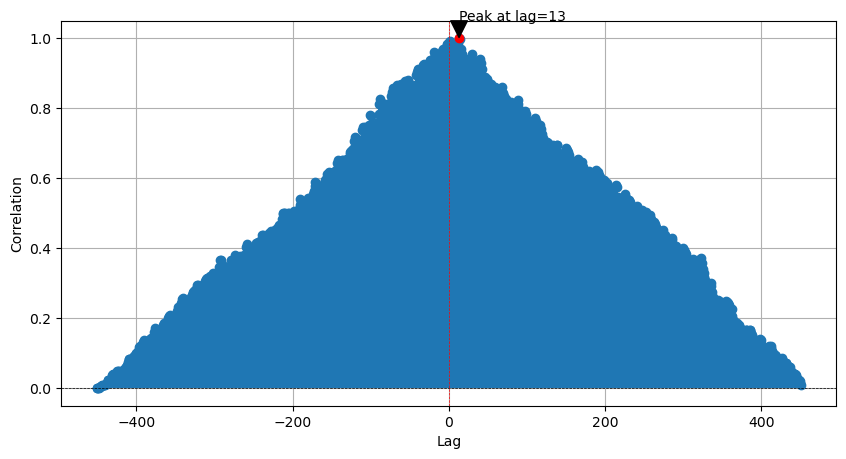

In [30]:
plot_ccf(x_df1, y_aff)

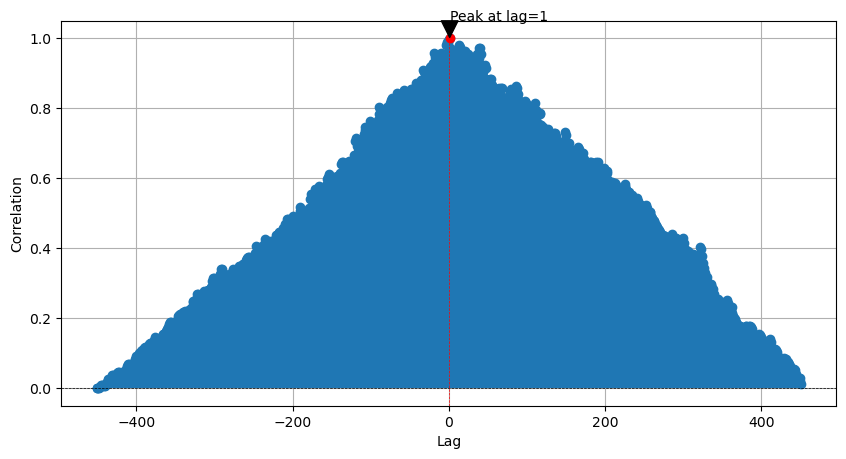

In [31]:
plot_ccf(x_df1, y_par)

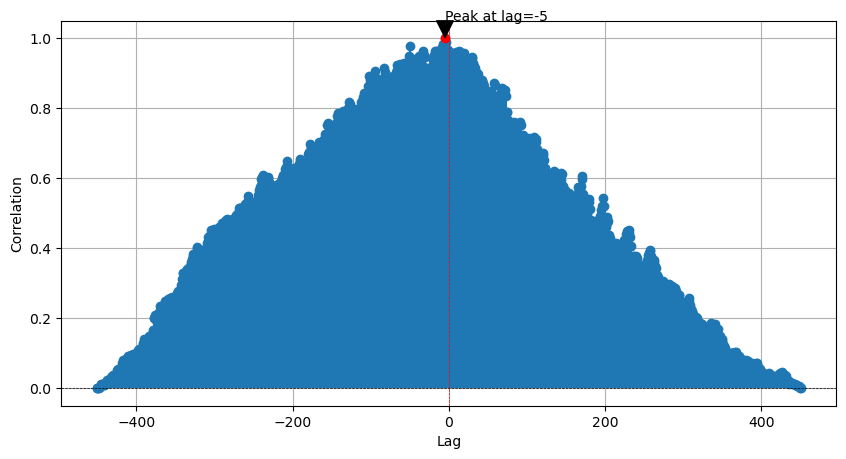

In [32]:
plot_ccf(x_df2a, y_aff)

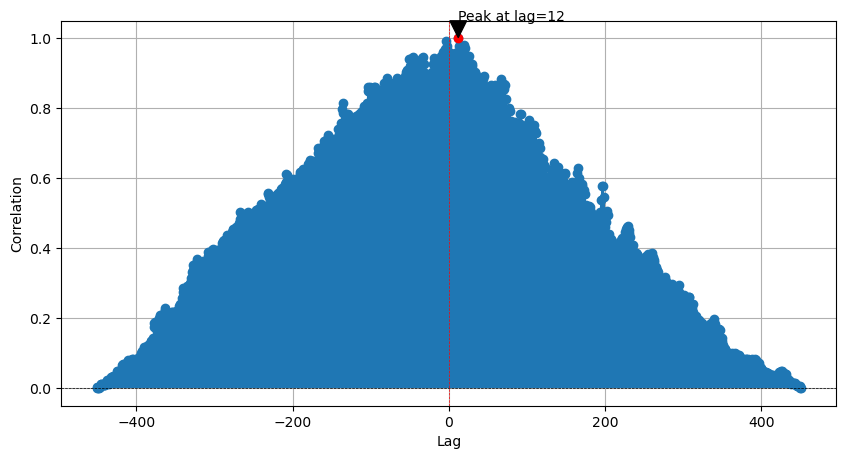

In [33]:
plot_ccf(x_df2a, y_par)

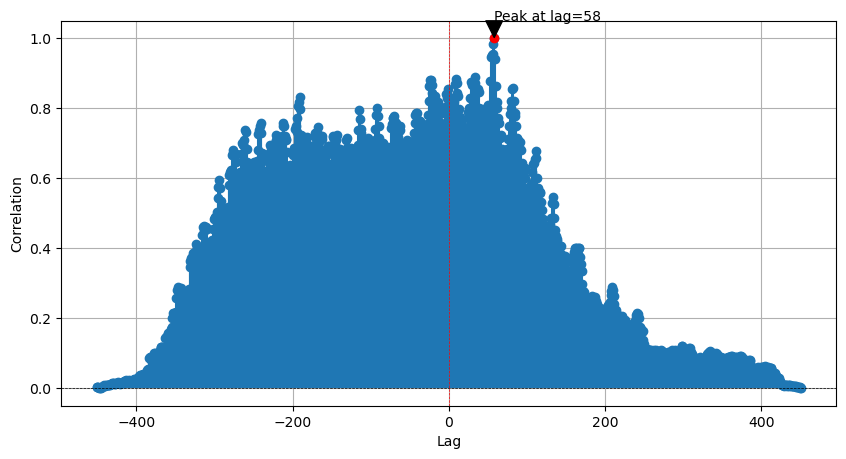

In [34]:
plot_ccf(x_df2b, y_aff)

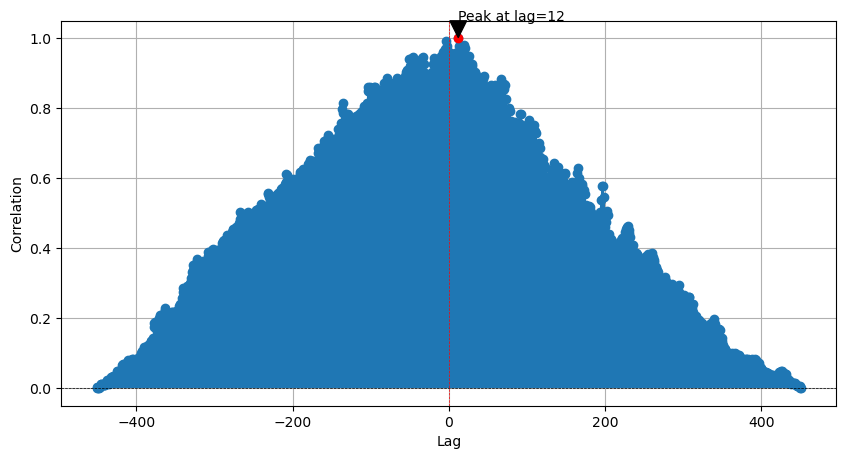

In [35]:
plot_ccf(x_df2a, y_par)